In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
#Finding columns and datatype
from sqlalchemy import inspect,func
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
rec_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
rec_date

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


('2017-08-23',)

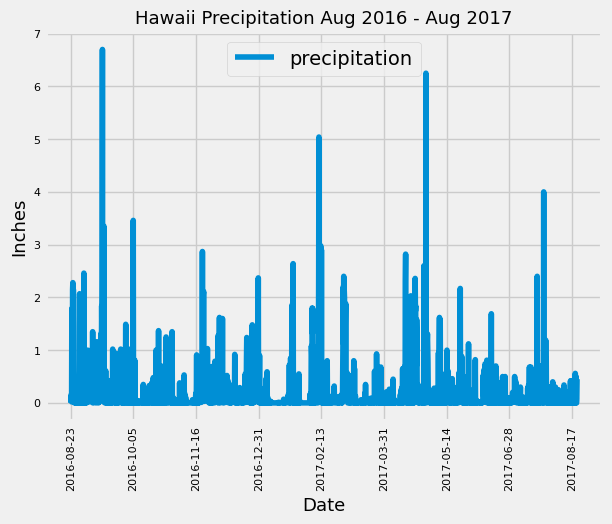

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
one_year= dt.date(2017, 8, 23)-dt.timedelta(days=365)
# Calculate the date one year from the last date in data set.
prev_last_date = dt.date(one_year.year, one_year.month, one_year.day)


# Perform a query to retrieve the data and precipitation scores
results= session.query(measurement.date, measurement.prcp).filter(measurement.date >= prev_last_date).order_by(measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names

data_df =pd.DataFrame(results, columns=['date', 'precipitation'])
# Sort the dataframe by date
data_df.set_index(data_df['date'], inplace =True)
clean_data_df = data_df.dropna()
# Use Pandas Plotting with Matplotlib to plot the data
clean_data_df.plot('date', 'precipitation')


plt.xlabel("Date",  size = 13)
plt.ylabel("Inches", size = 13)
plt.title("Hawaii Precipitation Aug 2016 - Aug 2017", size = 13)
plt.legend(["precipitation"],loc='upper center')
plt.xticks(rotation=90, size = 8)
plt.yticks(size = 8)
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
clean_data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
session.query(station.id).count()

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_Measurment_join=session.query(measurement.station,func.count(measurement.station)).\
                       group_by(measurement.station).\
                       order_by(func.count(measurement.station).desc()).all()
station_Measurment_join

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
results_temp=session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
             filter(measurement.station==station_Measurment_join[0][0]).all()
results_temp

[(54.0, 85.0, 71.66378066378067)]

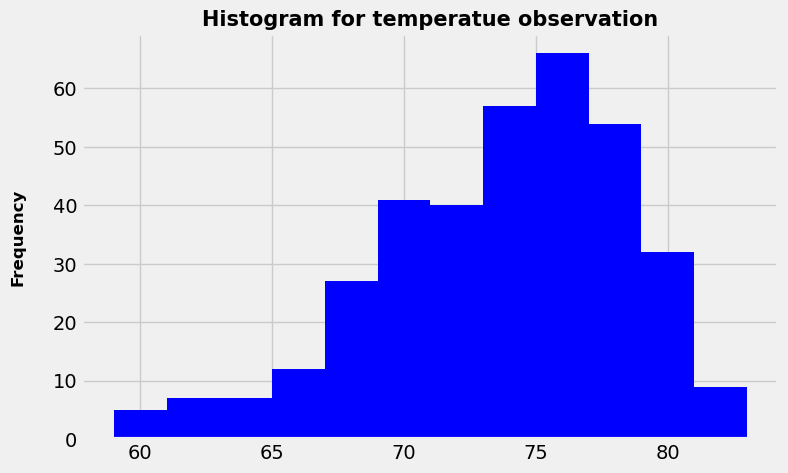

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results_date=session.query(measurement.date).order_by(measurement.date.desc()).\
             filter(measurement.station==station_Measurment_join[0][0]).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)

results_temp=session.query(measurement.tobs).\
             filter(measurement.station==station_Measurment_join[0][0]).\
             filter(measurement.date>=year_back).all()
df_results=pd.DataFrame(results_temp)


#Plotting Histogram
hist = df_results['tobs'].hist(bins=12,figsize=(8,5), color='b', zorder=2)

# Remove title
hist.set_title("Histogram for temperatue observation",weight='bold', size=15)

# Set y-axis label
hist.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

plt.show()

# Close Session

In [16]:
# Close Session
session.close()